In [1]:
import os
import pandas as pd
import pickle
from scipy.signal import welch, butter, filtfilt
from scipy.integrate import simpson
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.graphics import utils
from statsmodels.compat.python import lrange

# Serialize and Unserialize RAW data

In [2]:
column_names = [
    "Sample Index",
    "EEG Channel 0", "EEG Channel 1", "EEG Channel 2", "EEG Channel 3",
    "EEG Channel 4", "EEG Channel 5", "EEG Channel 6", "EEG Channel 7",
    "Accelerometer X", "Accelerometer Y", "Accelerometer Z",
    "Timestamp", "Timestamp (Formatted)"
]

# Walk through Data files, create dataframes, and pickle them
for root, dirs, files in os.walk('./Data'):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            relative_path = os.path.relpath(csv_path, './Data')
            pkl_path = os.path.join('./Data', relative_path).replace(".csv", ".pickle")

            os.makedirs(os.path.dirname(pkl_path), exist_ok=True)

            try:
                df = pd.read_csv(csv_path, sep='\t', header=None)
                # Just grab the first twelve and second to last columns
                df_filtered = df[list(df.columns[:12]) + [df.columns[-2]]].copy()
                # Create a new column with formatted timestamps
                df_filtered["Timestamp (Formatted)"] = pd.to_datetime(df_filtered.iloc[:, -1], unit='s', utc=True)
                # And update the column names
                df_filtered.columns = column_names
                # And cut off the first row
                df_filtered = df_filtered[1:].copy()
                # Finally, pickle the dataframe
                df_filtered.to_pickle(pkl_path)
            except Exception as e:
                print(f"Error processing {csv_path}: {e}")

In [3]:
# From pickles, create one large 'data' dataframe
# Structure: data[participant][category][Optional[task]][Optional[subtask]]
#   ex. data[1][Baselines]
#   ex. data[1][Rhythm][Karate]
#   ex. data[1][Reading][English][In]
data = {}

for root, _, files in os.walk('./Data'):
    for file in files:
        if file.endswith(".pickle") and root != './Data':
            filepath = os.path.join(root, file)
            parts = filepath.split(os.sep)
            df = pd.read_pickle(filepath)

            participant = parts[-2]
            category = parts[2]
            if category != 'Baselines':
                task = parts[3]
                if len(parts) > 6:
                    data.setdefault(participant, {}).setdefault(category, {}).setdefault(task, {})[parts[4]] = df
                else:
                    data.setdefault(participant, {}).setdefault(category, {})[task] = df
            else:
                data.setdefault(participant, {})[category] = df

with open('./Data/all_data_RAW.pickle', 'wb') as fp:
    pickle.dump(data, fp)

# Scale data up
# scale_factor = 4.5 / 24 / (2**23 - 1) * 1e6

# for participant in data:
#     for category in data[participant]:
#         category_data = data[participant][category]

#         if isinstance(category_data, dict):
#             for task in category_data:
#                 task_data = category_data[task]

#                 if isinstance(task_data, dict):
#                     for subtask in task_data:
#                         df = task_data[subtask]
#                         for ch in range(8):
#                             col = f"EEG Channel {ch}"
#                             df[col] = df[col] * scale_factor
#                 else:
#                     df = task_data
#                     for ch in range(8):
#                         col = f"EEG Channel {ch}"
#                         df[col] = df[col] * scale_factor
#         else:
#             df = category_data
#             for ch in range(8):
#                 col = f"EEG Channel {ch}"
#                 df[col] = df[col] * scale_factor

# with open('./Data/all_data_SCALED.pickle', 'ab') as fp:
#     pickle.dump(data, fp)
# with open('./Data/all_data_RAW.pickle', 'rb') as fp:
#     raw_data = pickle.load(fp)

# Serialize and Unserialize FILTERED data

In [4]:
def plot_data(data, title, path):
    fig, axs = plt.subplots(8, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, fontsize=16)

    colors = ['#afb6be', '#7c4b8d', '#36579e', '#317159', '#ddb20d', '#fd5e34', '#e0382d', '#a25231']
    for i, channel in enumerate([f"EEG Channel {i}" for i in range(8)]):
        axs[i].plot(data[channel], linewidth=1, color=colors[i])
        axs[i].set_ylabel(f"Channel {i}")
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].set_xticks([])

    plt.tight_layout(pad=0.5, h_pad=0)
    plt.subplots_adjust(top=0.95)
    plt.savefig(path)
    plt.close()


b, a = butter(2, (0.1, 70), 'bandpass', fs=250)
def filter_df(df):
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        df[ch] = filtfilt(b, a, df[ch])
    return df


data_filtered = {}
for participant in data:
    data_filtered[participant] = {}
    for task in data[participant]:
        if task == 'Baselines':
            df = data[participant][task]
            df_filtered = filter_df(df.copy())
            data_filtered[participant][task] = df_filtered
            plot_data(df_filtered, f'Participant no. {participant}: {task}', f'./Data/{task}/{participant}/{participant}_filtered.png')
        else:
            data_filtered[participant][task] = {}
            for subtask in data[participant][task]:
                if task == 'Reading':
                    data_filtered[participant][task][subtask] = {}
                    for direction in data[participant][task][subtask]:
                        df = data[participant][task][subtask][direction]
                        df_filtered = filter_df(df.copy())
                        data_filtered[participant][task][subtask][direction] = df_filtered
                        plot_data(df_filtered, f'Participant no. {participant}: {task}, {subtask} ({direction})', f'./Data/{task}/{subtask}/{direction}/{participant}/{participant}_filtered.png')
                else:
                    df = data[participant][task][subtask]
                    df_filtered = filter_df(df.copy())
                    data_filtered[participant][task][subtask] = df_filtered
                    plot_data(df_filtered, f'Participant no. {participant}: {task}, {subtask}', f'./Data/{task}/{subtask}/{participant}/{participant}_filtered.png')

with open('./Data/all_data_FILTERED.pickle', 'wb') as fp:
    pickle.dump(data_filtered, fp)

In [5]:
with open('./Data/all_data_FILTERED.pickle', 'rb') as fp:
    data_filtered = pickle.load(fp)

# Serialize and Unserialize Welch bandpower data

In [6]:
bands = [
    (0, 4, "Delta", "#e0382d"),
    (4, 8, "Theta", "#ddb20d"),
    (8, 10, "Alpha", "#317159"),
    (10, 13, "Mu", "#358a9e"),
    (13, 20, "Beta I", "#36579e"),
    (20, 50, "Beta II", "#48359e"),
    (50, 125, "Gamma", "#7c4b8d"),
]
def plot_welch(df, title, path):
    """ Welch Power Spectral Density """
    channels = [f"EEG Channel {i}" for i in range(8)]
    bandpowers = {ch: {} for ch in channels}
    fig, axs = plt.subplots(4, 2, figsize=(14, 10), sharex=True, sharey=True)
    axs = axs.flatten()

    for i, channel in enumerate(channels):
        freqs, power = welch(df[channel], fs=250, nperseg=1280)

        axs[i].semilogy(freqs, power, color='white')
        axs[i].set_title(f"{channel} Welch")
        axs[i].set_xlim([0, 80])
        axs[i].set_xticks([])
        axs[i].set_yticklabels([])
        axs[i].set_yticks([])
        axs[i].grid(True)
        
        for j, (low, high, label, color) in enumerate(bands):
            if high > 125:
                continue
            axs[i].axvspan(low, high, color=color, alpha=0.75, label=label)

            band_mask = (freqs >= low) & (freqs <= high)
            if np.any(band_mask):
                band_freqs = freqs[band_mask]
                band_power = power[band_mask]
                peak_idx = np.argmax(band_power)
                peak_freq = band_freqs[peak_idx]
                peak_pow = band_power[peak_idx]

                bandpowers[channel][label] = simpson(power[band_mask], freqs[band_mask])

                xoffset = 5 if j == 6 or j == 0 else 0
                yoffset = 10 if j == 0 else 0.001 if j % 2 == 1 or j == 6 else 30

                axs[i].annotate(f"{peak_freq:.1f} Hz",
                                xy=(peak_freq, peak_pow),
                                xytext=(peak_freq + xoffset, peak_pow * yoffset),
                                arrowprops=dict(arrowstyle="->", lw=0.8),
                                fontsize=8, ha='center')

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=7, fontsize='small', bbox_to_anchor=(0.7225, 0.9575))
    plt.suptitle(f"Welch Power Spectral Density - {title}", fontsize=16)
    fig.text(0.5, 0.01, 'Frequency (Hz)', ha='center', fontsize=12)
    fig.text(0.01, 0.5, 'Power (μV²/Hz)', va='center', rotation='vertical', fontsize=12)
    plt.tight_layout(pad=0.5, w_pad=1)
    plt.subplots_adjust(top=0.89, left=0.03, bottom=0.035)
    plt.savefig(path)
    plt.close()

    return bandpowers

data_bandpowers = {}
for participant in data_filtered:
    data_bandpowers[participant] = {}
    for task in data_filtered[participant]:
        if task == 'Baselines':
            df = data_filtered[participant][task].copy()
            data_bandpowers[participant][task] = plot_welch(df, f'Participant no. {participant}: {task}', f'./Data/{task}/{participant}/{participant}_Welch.png')
        else:
            data_bandpowers[participant][task] = {}
            for subtask in data_filtered[participant][task]:
                if task == 'Reading':
                    data_bandpowers[participant][task][subtask] = {}
                    for direction in data_filtered[participant][task][subtask]:
                        df = data_filtered[participant][task][subtask][direction].copy()
                        data_bandpowers[participant][task][subtask][direction] = plot_welch(df, f'Participant no. {participant}: {task}, {subtask} ({direction})', f'./Data/{task}/{subtask}/{direction}/{participant}/{participant}_Welch.png')
                else:
                    df = data_filtered[participant][task][subtask].copy()
                    data_bandpowers[participant][task][subtask] = plot_welch(df, f'Participant no. {participant}: {task}, {subtask}', f'./Data/{task}/{subtask}/{participant}/{participant}_Welch.png')

with open('./Data/all_data_BANDPOWERS.pickle', 'wb') as fp:
    pickle.dump(data_bandpowers, fp)

In [7]:
with open('./Data/all_data_BANDPOWERS.pickle', 'rb') as fp:
    data_bandpowers = pickle.load(fp)

# Univariate One-Way Repeated Measures ANOVA
F([DoF1], [DoF2]) = [p Value], p < [0.05, 0.01, or 0.001]

In [8]:
rows = []
for participant in data_bandpowers:
    for task in data_bandpowers[participant]:
        if task == 'Baselines':
            bandpowers = data_bandpowers[participant][task]
            for channel in bandpowers:
                for band in bandpowers[channel]:
                    rows.append({
                        "Participant": participant,
                        "Task": task,
                        "Channel": channel,
                        "Band": band,
                        "Power": bandpowers[channel][band]
                    })
        else:
            for subtask in data_bandpowers[participant][task]:
                if task == 'Reading':
                    for direction in data_bandpowers[participant][task][subtask]:
                        bandpowers = data_bandpowers[participant][task][subtask][direction]
                        for channel in bandpowers:
                            for band in bandpowers[channel]:
                                rows.append({
                                    "Participant": participant,
                                    "Task": ' '.join([task, subtask, direction]),
                                    "Channel": channel,
                                    "Band": band,
                                    "Power": bandpowers[channel][band]
                                })
                else:
                    if subtask == 'Sheet Music': continue
                    bandpowers = data_bandpowers[participant][task][subtask]
                    for channel in bandpowers:
                        for band in bandpowers[channel]:
                            rows.append({
                                "Participant": participant,
                                "Task": ' '.join([task, subtask]),
                                "Channel": channel,
                                "Band": band,
                                "Power": bandpowers[channel][band]
                            })

bandpower_df = pd.DataFrame(rows)
print(bandpower_df)

     Participant                 Task        Channel     Band         Power
0              0  Reading English Out  EEG Channel 0    Delta  4.583125e+04
1              0  Reading English Out  EEG Channel 0    Theta  1.446870e+03
2              0  Reading English Out  EEG Channel 0    Alpha  3.864119e+02
3              0  Reading English Out  EEG Channel 0       Mu  2.541186e+02
4              0  Reading English Out  EEG Channel 0   Beta I  3.942398e+02
...          ...                  ...            ...      ...           ...
2459           2       Writing French  EEG Channel 7    Alpha  4.434481e+00
2460           2       Writing French  EEG Channel 7       Mu  4.856475e+00
2461           2       Writing French  EEG Channel 7   Beta I  1.187015e+01
2462           2       Writing French  EEG Channel 7  Beta II  2.150719e+01
2463           2       Writing French  EEG Channel 7    Gamma  2.105779e+07

[2464 rows x 5 columns]


In [9]:
anova_results = []
tukey_results = []
for band in ['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']:
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        band_df = bandpower_df[
            (bandpower_df['Band'] == band) &
            (bandpower_df['Channel'] == ch)
        ].copy()

        anova_result = pg.rm_anova(
            data=band_df,
            dv='Power',
            within='Task',
            subject='Participant',
            # detailed=True
        )

        anova_results.append({
            'Channel': ch,
            'Band': band,
            'F Value': anova_result['F'][0],
            'DoF1': anova_result['ddof1'][0],
            'DoF2': anova_result['ddof2'][0],
            'p Value': anova_result['p-unc'][0],
            'Generalized Eta Squared': anova_result['ng2'][0]
        })

        tukey_result = pg.pairwise_tukey(
            data=band_df,
            dv='Power',
            between='Task'
        )
        # print(tukey_result)

        # tukey_results.append({

        # })

anova_results = pd.DataFrame(anova_results)

In [10]:
# p-value should be:
#   < 0.05  : good
#   < 0.01  : great
#   < 0.001 : ideal
print(anova_results[anova_results['p Value'] < 0.05])
# eta-squared should be:
#   0.01 : small effect size
#   0.06 : medium effect size
#   0.14 : large effect size
# print(anova_results[anova_results['Generalized Eta Squared'] > 0.14])

          Channel     Band   F Value  DoF1  DoF2   p Value  \
36  EEG Channel 4   Beta I  3.011290    10    30  0.009399   
37  EEG Channel 5   Beta I  2.677319    10    30  0.018001   
44  EEG Channel 4  Beta II  3.334472    10    30  0.005090   
45  EEG Channel 5  Beta II  2.188131    10    30  0.047689   

    Generalized Eta Squared  
36                 0.445777  
37                 0.445281  
44                 0.515694  
45                 0.392087  


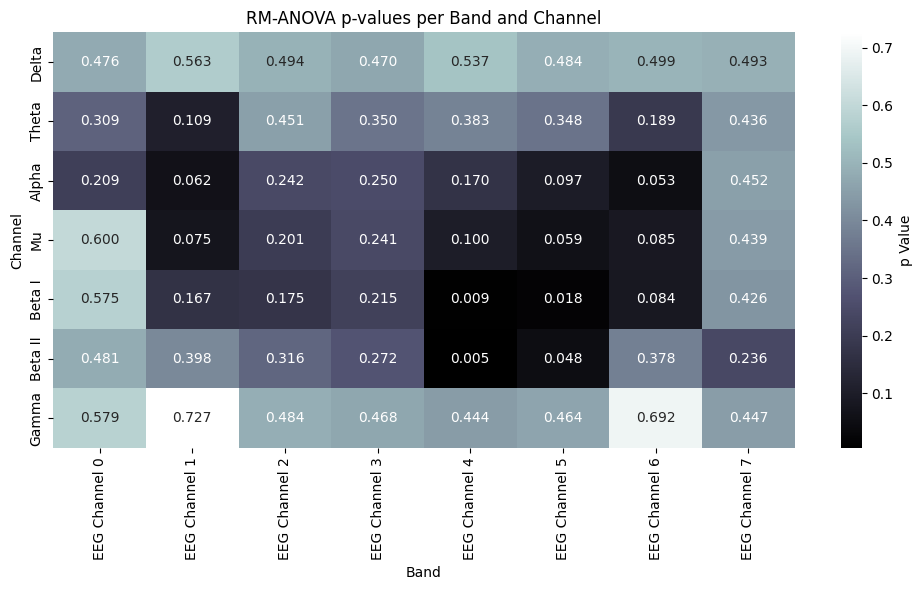

In [11]:
anova_results_pivoted = anova_results.pivot(index="Band", columns="Channel", values="p Value").loc[['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']]

plt.figure(figsize=(10, 6))
sns.heatmap(anova_results_pivoted, annot=True, fmt=".3f", cmap="bone", cbar_kws={"label": "p Value"})
plt.title("RM-ANOVA p-values per Band and Channel")
plt.ylabel("Channel")
plt.xlabel("Band")
plt.tight_layout()
plt.savefig('./Data/RM-ANOVA_pValue_heatmap')
plt.show()

Empty DataFrame
Columns: [Channel, Band, F Value, DoF1, DoF2, p Value, Generalized Eta Squared, p Bonferroni]
Index: []
Empty DataFrame
Columns: [Channel, Band, F Value, DoF1, DoF2, p Value, Generalized Eta Squared]
Index: []


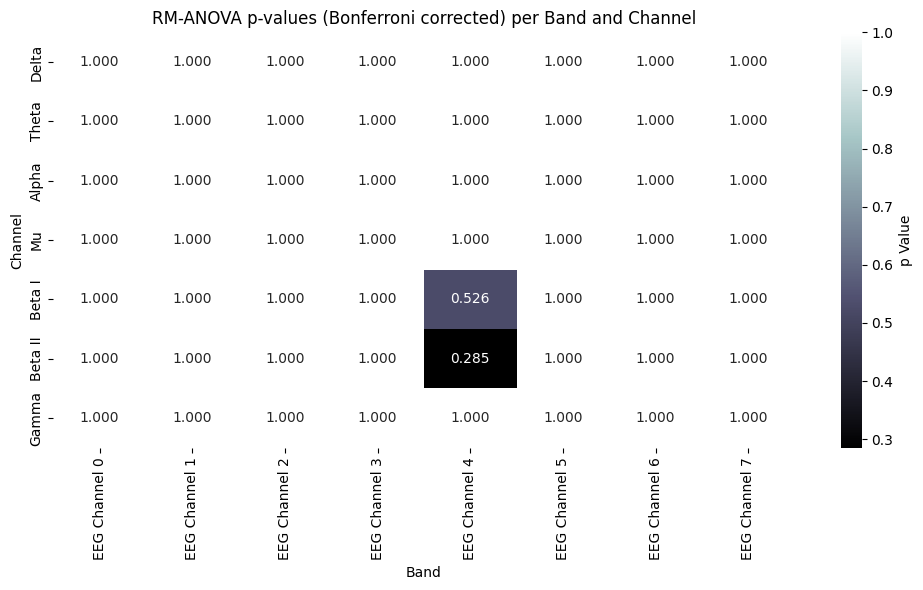

In [12]:
anova_results_bonferroni = anova_results.copy()
# Bonferroni Correction
N = len(anova_results_bonferroni)

anova_results_bonferroni["p Bonferroni"] = anova_results_bonferroni["p Value"] * N
anova_results_bonferroni["p Bonferroni"] = anova_results_bonferroni["p Bonferroni"].clip(upper=1.0)
print(anova_results_bonferroni[anova_results_bonferroni["p Bonferroni"] < 0.05])
print(anova_results[anova_results["p Value"] < (0.05 / N)])

anova_results_bonferroni_pivoted = anova_results_bonferroni.pivot(index="Band", columns="Channel", values="p Bonferroni").loc[['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']]

plt.figure(figsize=(10, 6))
sns.heatmap(anova_results_bonferroni_pivoted, annot=True, fmt=".3f", cmap="bone", cbar_kws={"label": "p Value"})
plt.title("RM-ANOVA p-values (Bonferroni corrected) per Band and Channel")
plt.ylabel("Channel")
plt.xlabel("Band")
plt.tight_layout()
plt.savefig('./Data/RM-ANOVA_Bonferroni_heatmap')
plt.show()

# Paired t-test

In [13]:
ttest_results = []
for band in ['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']:
    for ch in [f"EEG Channel {i}" for i in range(8)]:
        for eng_task, fr_task in [
            ("Reading English In", "Reading French In"),
            ("Reading English Out", "Reading French Out"),
            ("Speaking English", "Speaking French"),
            ("Writing English", "Writing French"),
        ]:
            df_eng = bandpower_df[
                (bandpower_df["Band"] == band) &
                (bandpower_df["Channel"] == ch) &
                (bandpower_df["Task"] == eng_task)
            ][["Participant", "Power"]].rename(columns={"Power": "Power_en"})
            df_fr = bandpower_df[
                (bandpower_df["Band"] == band) &
                (bandpower_df["Channel"] == ch) &
                (bandpower_df["Task"] == fr_task)
            ][["Participant", "Power"]].rename(columns={"Power": "Power_fr"})
            df_merged = pd.merge(df_eng, df_fr, on="Participant")

            result = pg.ttest(
                df_merged["Power_en"],
                df_merged["Power_fr"],
                paired=True,
                alternative='two-sided'
            )

            ttest_results.append({
                "Band": band,
                "Channel": ch,
                "Task": eng_task.replace(' English', ''),
                "DoF": result['dof'][0],
                "T": result['T'][0],
                "p Value": result['p-val'][0],
                "Cohen d": result['cohen-d'][0]
            })

ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values("p Value")

/var/folders/kt/rq_fnm7978g0m_s5fz41mb3c0000gn/T/ipykernel_61002/1994901704.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "DoF": result['dof'][0],
/var/folders/kt/rq_fnm7978g0m_s5fz41mb3c0000gn/T/ipykernel_61002/1994901704.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "T": result['T'][0],
/var/folders/kt/rq_fnm7978g0m_s5fz41mb3c0000gn/T/ipykernel_61002/1994901704.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "p 

In [14]:
# p-value should be:
#   < 0.05  : good
#   < 0.01  : great
#   < 0.001 : ideal
print(ttest_df[ttest_df['p Value'] < 0.05])
# eta-squared should be:
#   0.01 : small effect size
#   0.06 : medium effect size
#   0.14 : large effect size
print(ttest_df[ttest_df['Cohen d'] > 0.8])

        Band        Channel      Task  DoF         T   p Value   Cohen d
154   Beta I  EEG Channel 6  Speaking    3 -6.746465  0.006651  0.628952
110       Mu  EEG Channel 3  Speaking    3 -4.479304  0.020746  1.749550
182  Beta II  EEG Channel 5  Speaking    3 -3.285471  0.046235  0.070633
        Band        Channel         Task  DoF         T   p Value   Cohen d
110       Mu  EEG Channel 3     Speaking    3 -4.479304  0.020746  1.749550
118       Mu  EEG Channel 5     Speaking    3 -3.122659  0.052363  1.573811
70     Alpha  EEG Channel 1     Speaking    3 -3.113671  0.052731  2.044493
157   Beta I  EEG Channel 7  Reading Out    3 -2.698990  0.073849  0.812353
102       Mu  EEG Channel 1     Speaking    3 -2.643910  0.077396  1.880639
89     Alpha  EEG Channel 6  Reading Out    3 -2.579803  0.081794  1.263862
122       Mu  EEG Channel 6     Speaking    3 -2.231063  0.111886  1.365454
90     Alpha  EEG Channel 6     Speaking    3 -2.139537  0.121906  1.463566
106       Mu  EEG Channe

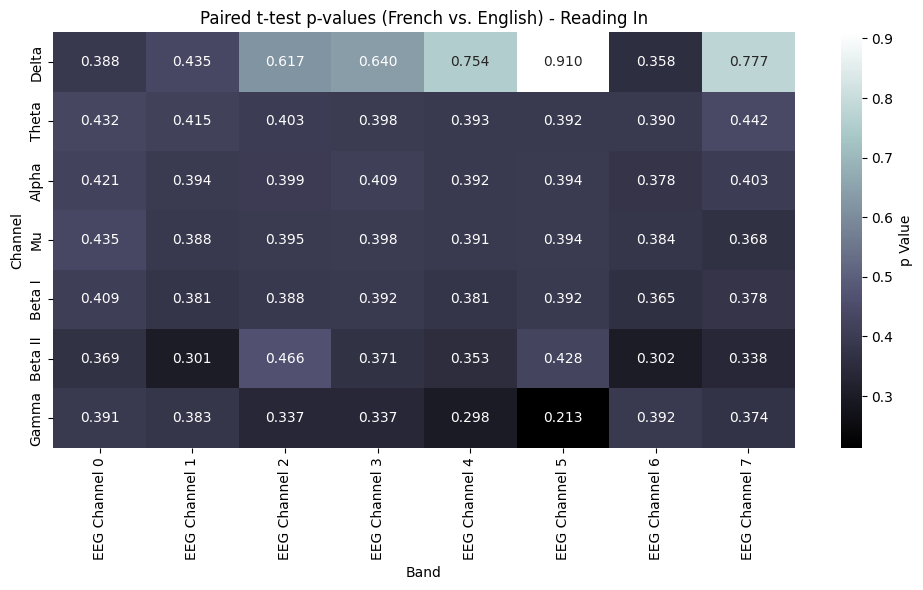

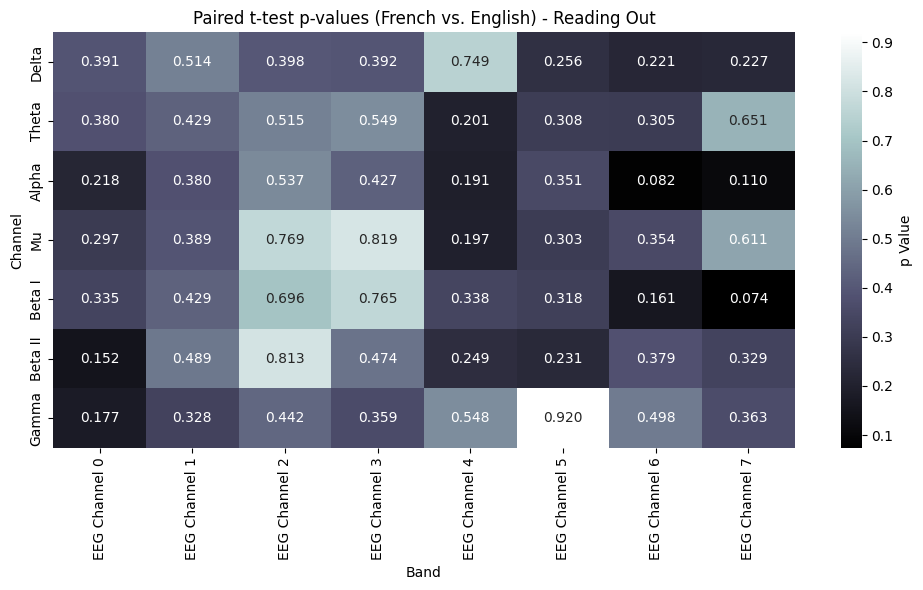

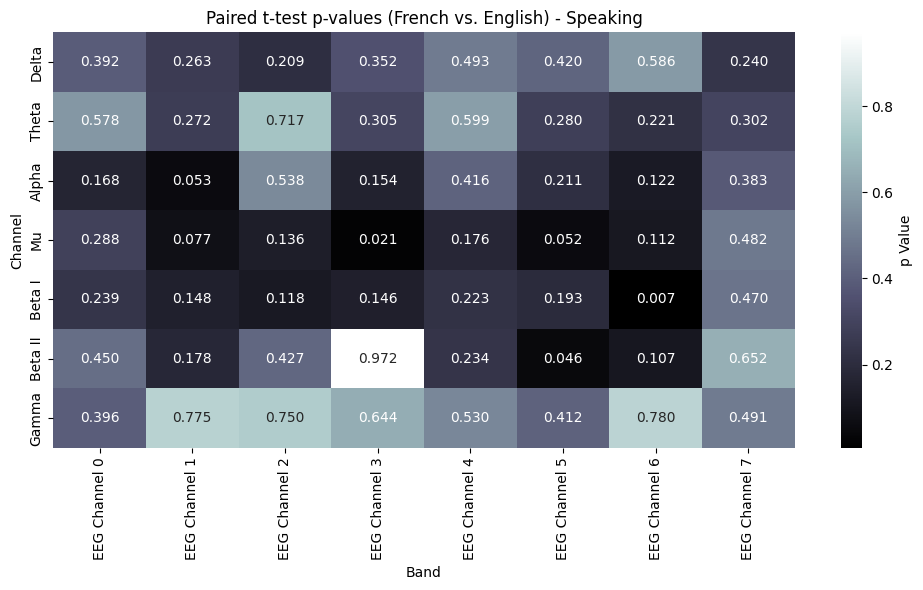

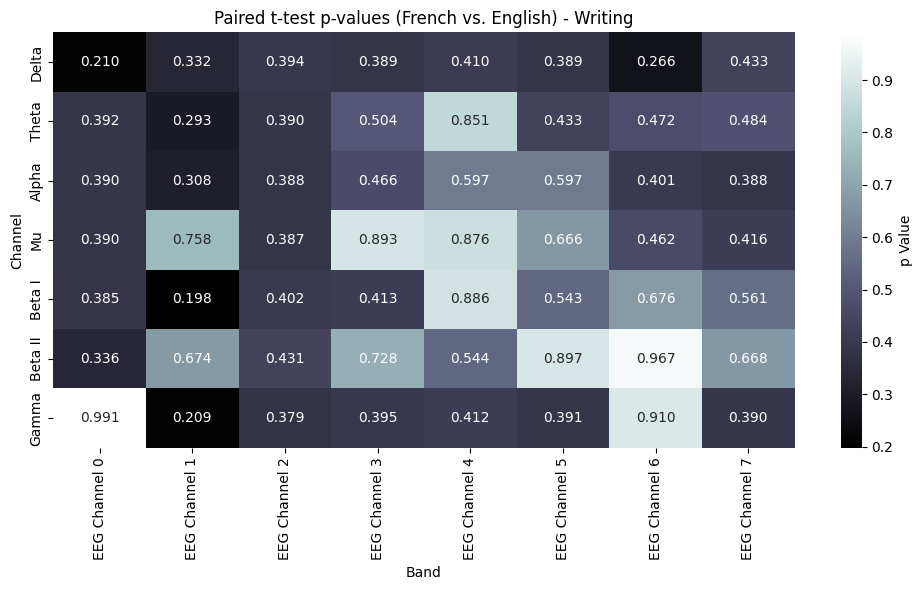

In [15]:
for task in ['Reading In', 'Reading Out', 'Speaking', 'Writing']:
    ttest_df_pivoted = ttest_df[ttest_df["Task"] == task].pivot(index="Band", columns="Channel", values="p Value").loc[['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']]

    plt.figure(figsize=(10, 6))
    sns.heatmap(ttest_df_pivoted, annot=True, fmt=".3f", cmap="bone", cbar_kws={"label": "p Value"})
    plt.title(f"Paired t-test p-values (French vs. English) - {task}")
    plt.ylabel("Channel")
    plt.xlabel("Band")
    plt.tight_layout()
    if len(task := task.split()) > 1:
        plt.savefig(f'./Data/{task[0]}/({task[1]})paired_ttest_pValue_heatmap')
    else:
        plt.savefig(f'./Data/{task[0]}/paired_ttest_pValue_heatmap')
    plt.show()

Empty DataFrame
Columns: [Band, Channel, Task, DoF, T, p Value, Cohen d, p Bonferroni]
Index: []
Empty DataFrame
Columns: [Band, Channel, Task, DoF, T, p Value, Cohen d]
Index: []


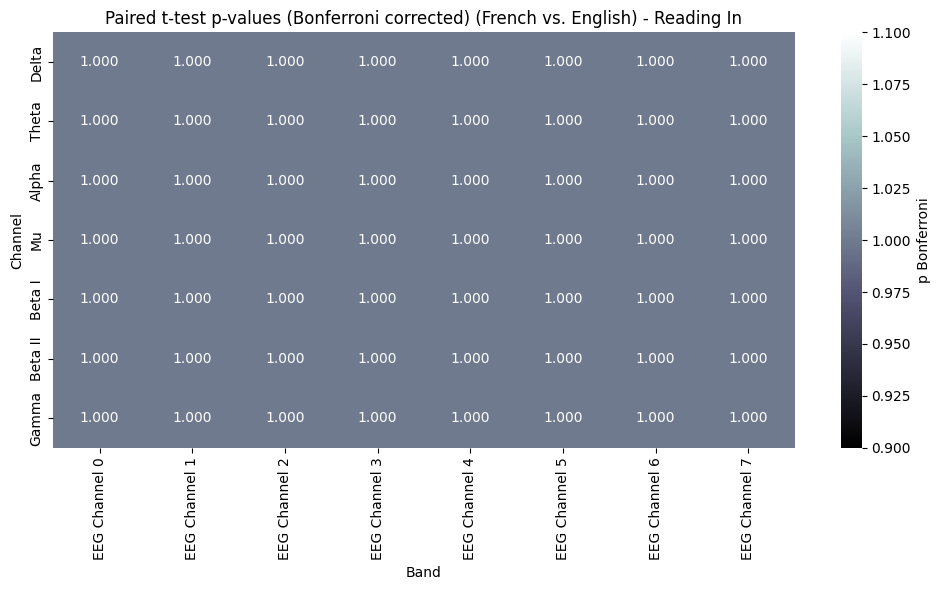

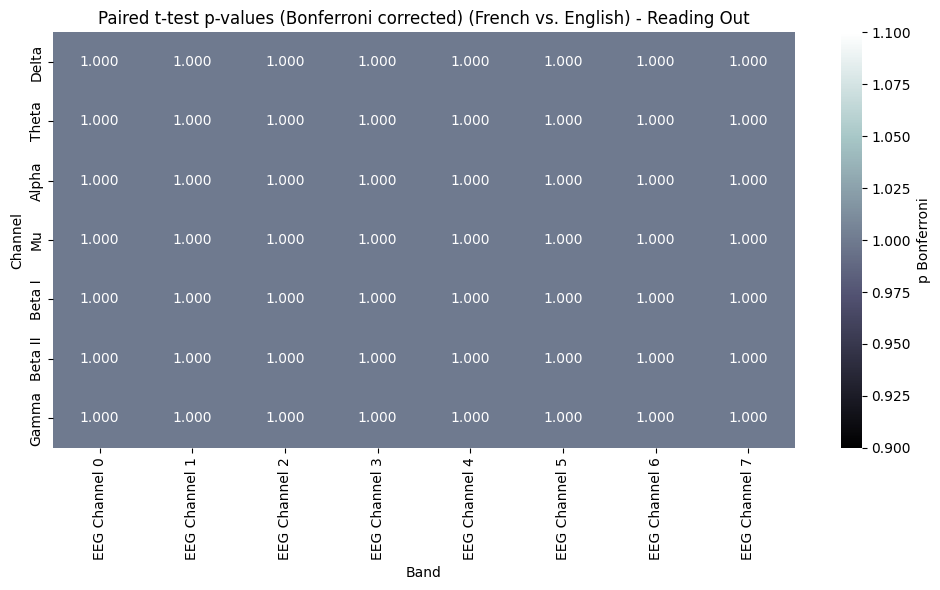

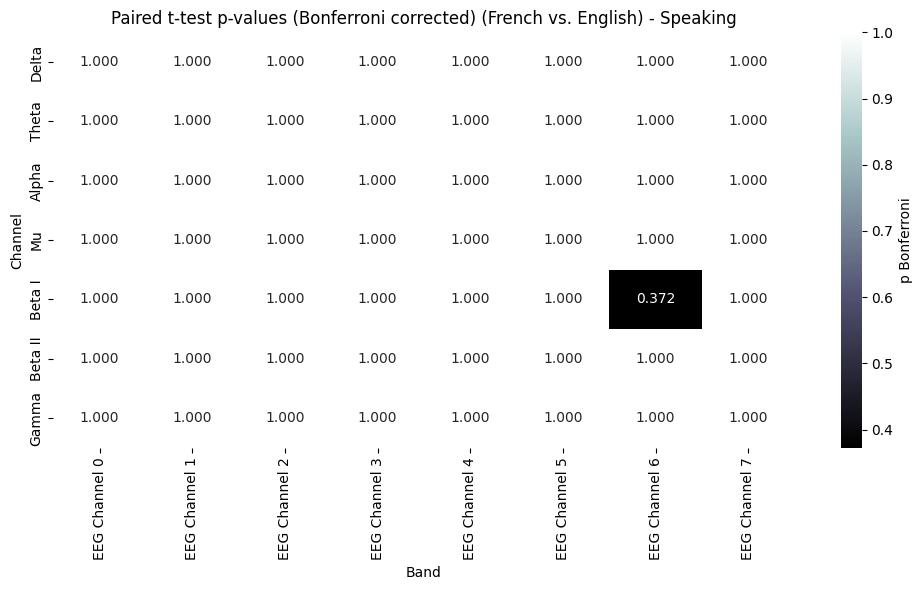

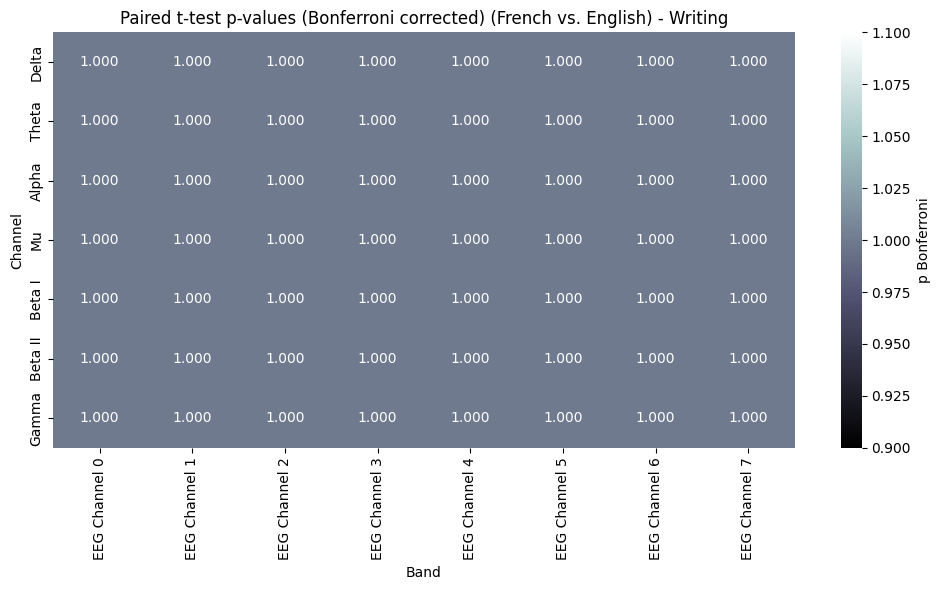

In [16]:
ttest_df_bonferroni = ttest_df.copy()
# Bonferroni Correction
N = len(ttest_df_bonferroni) / 4

ttest_df_bonferroni["p Bonferroni"] = ttest_df_bonferroni["p Value"] * N
ttest_df_bonferroni["p Bonferroni"] = ttest_df_bonferroni["p Bonferroni"].clip(upper=1.0)
print(ttest_df_bonferroni[ttest_df_bonferroni["p Bonferroni"] < 0.05])
print(ttest_df[ttest_df["p Value"] < (0.05 / N)])

for task in ['Reading In', 'Reading Out', 'Speaking', 'Writing']:
    ttest_df_bonferroni_pivoted = ttest_df_bonferroni[ttest_df_bonferroni["Task"] == task].pivot(index="Band", columns="Channel", values="p Bonferroni").loc[['Delta', 'Theta', 'Alpha', 'Mu', 'Beta I', 'Beta II', 'Gamma']]

    plt.figure(figsize=(10, 6))
    sns.heatmap(ttest_df_bonferroni_pivoted, annot=True, fmt=".3f", cmap="bone", cbar_kws={"label": "p Bonferroni"})
    plt.title(f"Paired t-test p-values (Bonferroni corrected) (French vs. English) - {task}")
    plt.ylabel("Channel")
    plt.xlabel("Band")
    plt.tight_layout()
    if len(task := task.split()) > 1:
        plt.savefig(f'./Data/{task[0]}/({task[1]})paired_ttest_Bonferroni_heatmap')
    else:
        plt.savefig(f'./Data/{task[0]}/paired_ttest_Bonferroni_heatmap')
    plt.show()

# Tukey HSD + Filtering Interesting Data

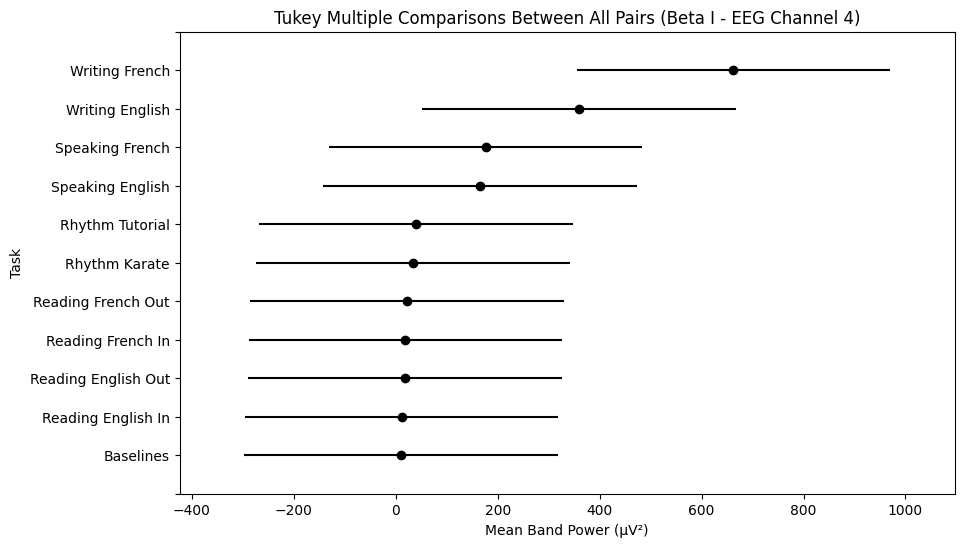

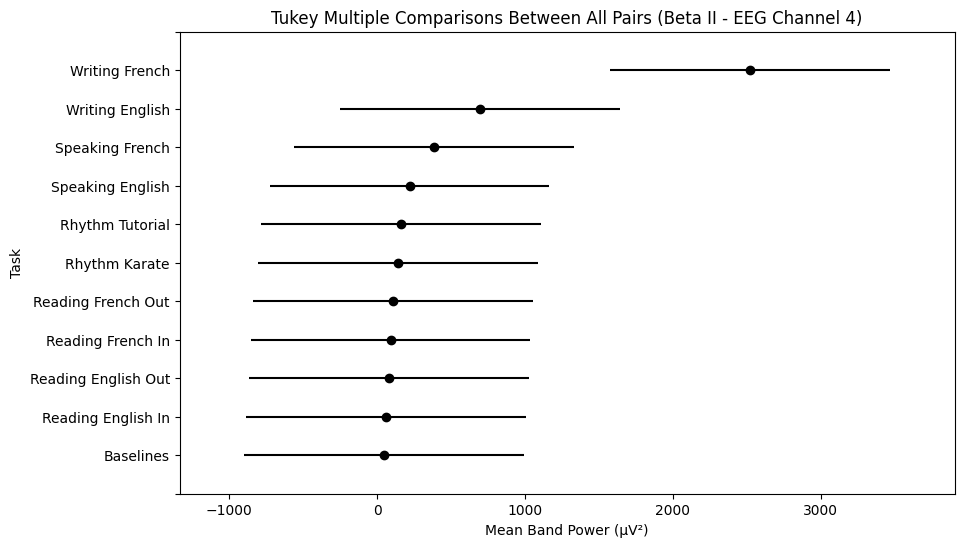

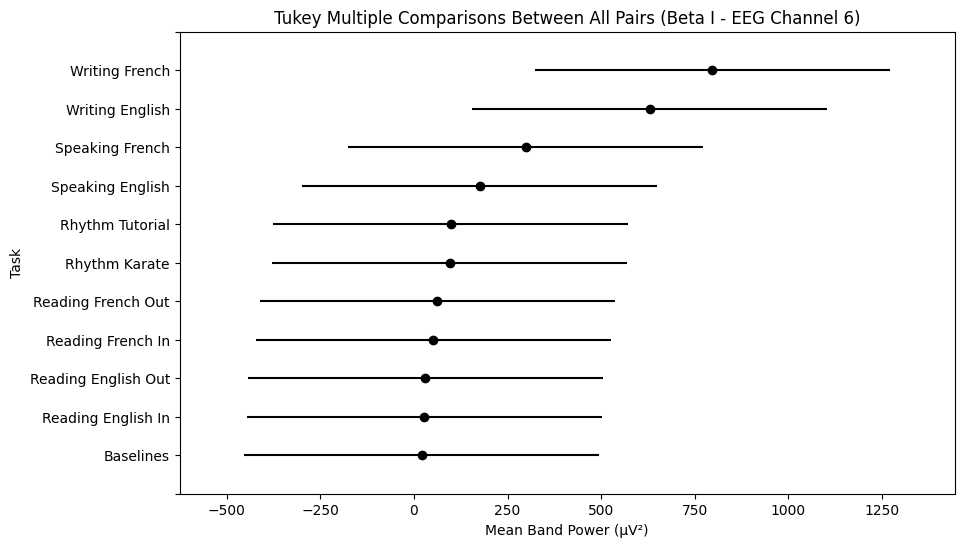

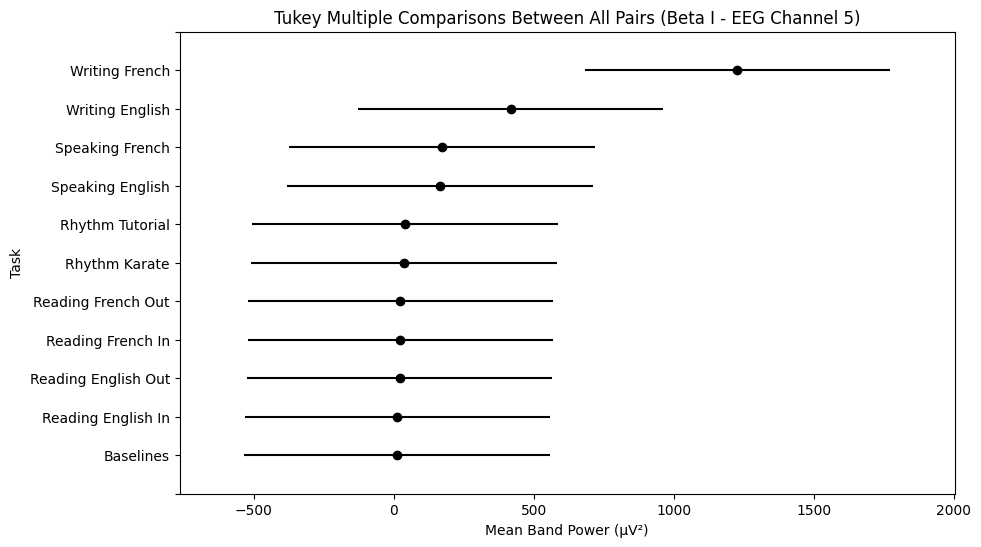

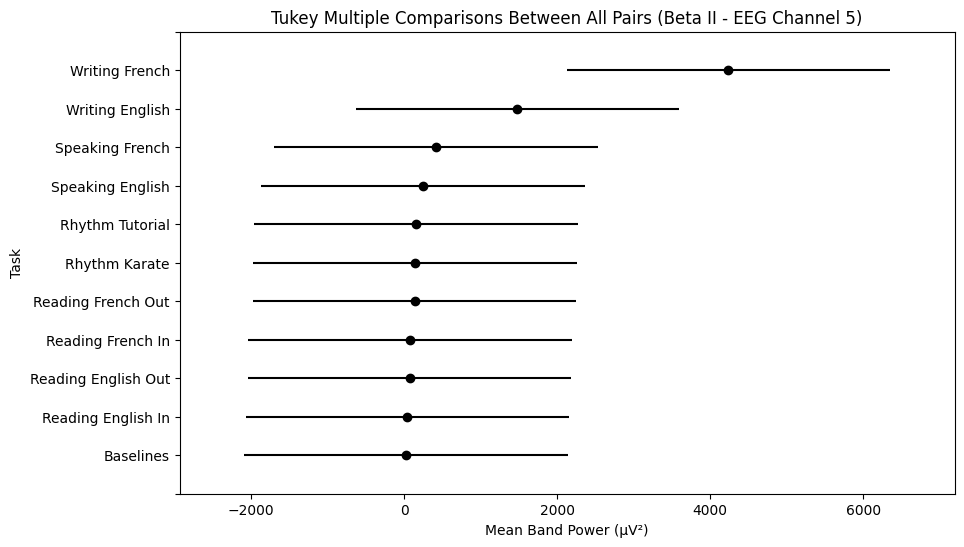

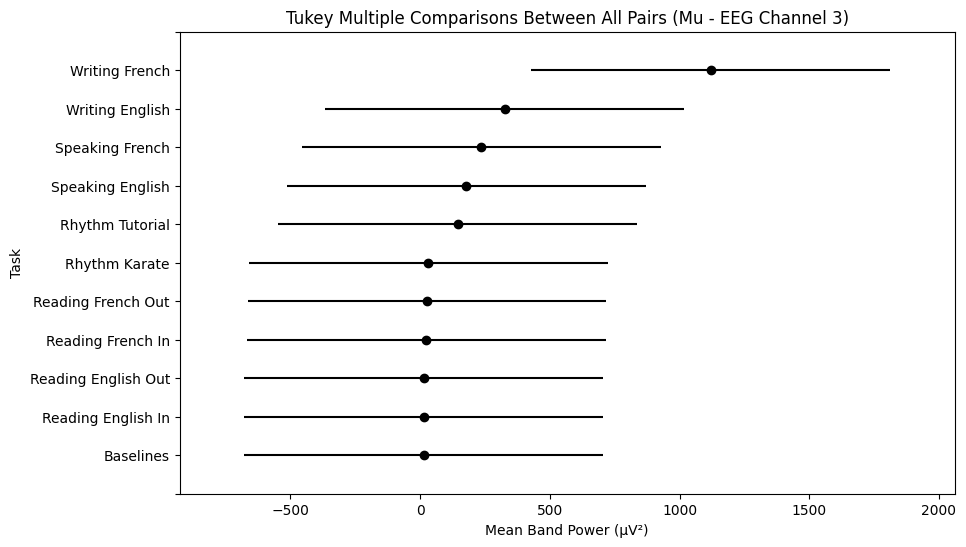

In [17]:
band_channel_combos = [
    # Low (p < 1.0) post-Bonferroni p-Values
    #   ANOVA
    ("Beta I", "EEG Channel 4"),
    ("Beta II", "EEG Channel 4"),
    #   ttest
    ("Beta I", "EEG Channel 6"),
    # Low (p < 0.05) pre-Bonferroni p-Values
    #   ANOVA
    ("Beta I", "EEG Channel 5"),
    ("Beta II", "EEG Channel 5"),
    #   ttest
    # ("Beta II", "EEG Channel 5"),
    ("Mu", "EEG Channel 3"),
]

tukey_rows = []
for band, channel in band_channel_combos:
    df = bandpower_df[(bandpower_df["Band"] == band) & (bandpower_df["Channel"] == channel)]

    mc = MultiComparison(df["Power"], df["Task"])
    tukey_result = mc.tukeyhsd()

    for i in range(len(tukey_result._results_table.data[1:])):  # skip header row
        row = tukey_result._results_table.data[i + 1]
        tukey_rows.append({
            "Band": band,
            "Channel": channel,
            "Task 1": row[0],
            "Task 2": row[1],
            "Mean Diff": row[2],
            "p Tukey": row[3],
            "Lower CI": row[4],
            "Upper CI": row[5],
            "Reject": row[6]
        })

    # Modification of statsmodels.sandbox.stats.multicomp.TukeyHSDResults.plot_simultaneous
    fig, ax1 = utils.create_mpl_ax(None)
    fig.set_size_inches((10, 6))
    if getattr(tukey_result, 'halfwidths', None) is None:
        tukey_result._simultaneous_ci()
    means = tukey_result._multicomp.groupstats.groupmean
    # This is the modification (sorting the means)
    means.sort()


    sigidx = []
    nsigidx = []
    minrange = [means[i] - tukey_result.halfwidths[i] for i in range(len(means))]
    maxrange = [means[i] + tukey_result.halfwidths[i] for i in range(len(means))]

    ax1.errorbar(means, lrange(len(means)), xerr=tukey_result.halfwidths, marker='o', linestyle='None', color='k', ecolor='k')

    ax1.set_title(f'Tukey Multiple Comparisons Between All Pairs ({band} - {channel})')
    r = np.max(maxrange) - np.min(minrange)
    ax1.set_ylim([-1, tukey_result._multicomp.ngroups])
    ax1.set_xlim([np.min(minrange) - r / 10., np.max(maxrange) + r / 10.])
    ylbls = [""] + tukey_result.groupsunique.astype(str).tolist() + [""]
    ax1.set_yticks(np.arange(-1, len(means) + 1))
    ax1.set_yticklabels(ylbls)
    ax1.set_xlabel("Mean Band Power (μV²)")
    ax1.set_ylabel("Task")
    plt.show()
tukey_summary_df = pd.DataFrame(tukey_rows)

In [18]:
summary_df = (
    bandpower_df
    .groupby(["Band", "Task", "Channel"])
    .agg(
        Mean_Power=("Power", "mean"),
        Std_Dev=("Power", "std")
    )
    .reset_index()
)

summary_df = summary_df[
    ((summary_df['Band'] == 'Beta I') &
    ((summary_df['Channel'] == 'EEG Channel 4') |
    (summary_df['Channel'] == 'EEG Channel 5') |
    (summary_df['Channel'] == 'EEG Channel 6'))) |
    ((summary_df['Band'] == 'Mu') &
    (summary_df['Channel'] == 'EEG Channel 3')) |
    ((summary_df['Band'] == 'Beta II') &
    ((summary_df['Channel'] == 'EEG Channel 4') |
    (summary_df['Channel'] == 'EEG Channel 5')))
]

def parse_base_task_and_language(task):
    words = task.split()
    if "French" in words:
        words.remove("French")
    elif "English" in words:
        words.remove("English")

    return " ".join(words).strip()
summary_df[["Base Task"]] = summary_df["Task"].apply(
    lambda t: pd.Series(parse_base_task_and_language(t))
)
summary_df = summary_df[summary_df["Base Task"].isin(['Reading In', 'Reading Out', 'Speaking', 'Writing'])]

def get_lang_comparison_stats(row):
    match = ttest_df[
        (ttest_df["Band"] == row["Band"]) &
        (ttest_df["Channel"] == row["Channel"]) &
        (ttest_df["Task"] == row["Base Task"])
    ]
    
    return pd.Series([match["Cohen d"].values[0]])
summary_df[["Cohen d"]] = summary_df.apply(get_lang_comparison_stats, axis=1)

summary_df = pd.merge(
    summary_df,
    anova_results[["Channel", "Band", "Generalized Eta Squared"]],
    on=["Channel", "Band"],
    how="left"
)

band_label_map = {
    "Delta": "Delta (0-4 Hz)",
    "Theta": "Theta (4-8 Hz)",
    "Alpha": "Alpha (8-10 Hz)",
    "Mu": "Mu (10-13 Hz)",
    "Beta I": "Beta I (13-20 Hz)",
    "Beta II": "Beta II (20-50 Hz)",
    "Gamma": "Gamma (50-125 Hz)"
}

channel_region_map = {
    "EEG Channel 3": "EEG Channel 3: C4 (Central Right)",
    "EEG Channel 4": "EEG Channel 4: P7 (Parietal Left)",
    "EEG Channel 5": "EEG Channel 5: P8 (Parietal Right)",
    "EEG Channel 6": "EEG Channel 6: O1 (Occipital Left)"
}
summary_df["Channel"] = summary_df["Channel"].replace(channel_region_map)
summary_df.rename(columns={'Channel': 'Channel (0-indexed)'}, inplace=True)

summary_df["Band"] = summary_df["Band"].replace(band_label_map)

# summary_df["Task Rank (Power)"] = summary_df.groupby(["Band", "Channel"])["Mean_Power"].rank(ascending=False)

summary_df

,Band,Task,Channel (0-indexed),Mean_Power,Std_Dev,Base Task,Cohen d,Generalized Eta Squared
0,Beta I (13-20 Hz),Reading English In,EEG Channel 4: P7 (Parietal Left),165.785668,308.774248,Reading In,0.705921,0.445777
1,Beta I (13-20 Hz),Reading English In,EEG Channel 5: P8 (Parietal Right),165.036855,305.966370,Reading In,0.703863,0.445281
2,Beta I (13-20 Hz),Reading English In,EEG Channel 6: O1 (Occipital Left),175.400337,296.556565,Reading In,0.736348,0.361181
3,Beta I (13-20 Hz),Reading English Out,EEG Channel 4: P7 (Parietal Left),39.527305,9.580173,Reading Out,0.791893,0.445777
4,Beta I (13-20 Hz),Reading English Out,EEG Channel 5: P8 (Parietal Right),39.521711,13.649402,Reading Out,0.802231,0.445281
5,Beta I (13-20 Hz),Reading English Out,EEG Channel 6: O1 (Occipital Left),98.105483,86.126883,Reading Out,1.304525,0.361181
6,Beta I (13-20 Hz),Reading French In,EEG Channel 4: P7 (Parietal Left),11.604184,8.112398,Reading In,0.705921,0.445777
7,Beta I (13-20 Hz),Reading French In,EEG Channel 5: P8 (Parietal Right),12.737798,4.664232,Reading In,0.703863,0.445281
8,Beta I (13-20 Hz),Reading French In,EEG Channel 6: O1 (Occipital Left),20.936342,7.841533,Reading In,0.736348,0.361181
9,Beta I (13-20 Hz),Reading French Out,EEG Channel 4: P7 (Parietal Left),176.583676,244.576611,Reading Out,0.791893,0.445777
